In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
from collections import OrderedDict
from sklearn.preprocessing import MinMaxScaler

In [2]:
training_ask = './Data/EURUSD_Candlestick_1_M_ASK_12.03.2016-12.03.2019.csv'
training_bid = './Data/EURUSD_Candlestick_1_M_BID_12.03.2016-12.03.2019.csv'


def prepare_data(file1,file2):
    data = pd.DataFrame()
    data1 = pd.read_csv(file1)
    data2 = pd.read_csv(file2)
    data['Date'] = data1['Local time']
    data['Date'] = data['Date'].map(lambda x: x.rstrip(' GMT-0500'))
    data['Date'] = pd.to_datetime(data['Date'])
    data[['Open','High','Low','Close','Volume']] = (data1[['Open','High','Low','Close','Volume']] + data2[['Open','High','Low','Close','Volume']])/2
    data = data.set_index(data['Date'])
    data = data[data['Volume'] > 0]
    return data[['Open','High','Low','Close','Volume']].round(4)

In [3]:
data = prepare_data(training_ask,training_bid)

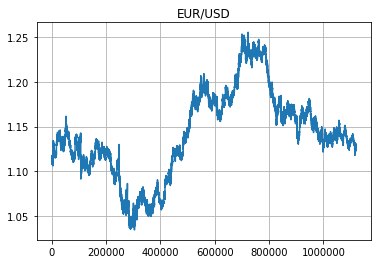

In [71]:
plt.plot(data.loc[:,'Close'].values)
plt.title('EUR/USD')
plt.grid(True)
plt.savefig('/Users/stevenovis/Desktop/final_project/eurusd')
plt.show()

In [57]:
train = data.ix[:'2018-11-30','Close']
test = data.ix['2018-12-01':, 'Close']

In [58]:
scaler = MinMaxScaler(feature_range = (-1,1))

In [59]:
train_scaled = scaler.fit_transform(train.values.reshape(-1,1)) 
test_scaled = scaler.fit_transform(test.values.reshape(-1,1))

In [60]:
def create_data(data, steps = 1):
    x = []
    y = []
    for i in range(0,len(data)-steps-1):
        a = data[i:(i+steps),0]
        x.append(a)
        y.append(data[i+steps,0])
    return np.array(x), np.array(y)

In [61]:
xtrain, ytrain = create_data(train_scaled)

In [62]:
xtest, ytest = create_data(test_scaled)

In [63]:
xtrain = np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1], 1))
xtest = np.reshape(xtest,(xtest.shape[0], xtest.shape[1], 1))

In [13]:
print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)

(1017149, 1, 1) (433902, 1, 1) (1017149,) (433902,)


In [46]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Flatten
from keras.models import load_model 
import time

/Users/stevenovis/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [19]:
model = Sequential()

model.add(LSTM(units = 60, return_sequences=True)) #first lstm
model.add(Dropout(0.2))#drop out 20% of the date
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='adam', metrics = ['accuracy'])
print ('compilation time : ', time.time() - start)

compilation time :  0.11832714080810547


/Users/stevenovis/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  


In [24]:
model.fit(xtrain, ytrain, batch_size=30, epochs=100, validation_split=0.05, verbose = 1)

Train on 966291 samples, validate on 50858 samples
Epoch 1/100
966291/966291 [==============================] - 309s 320us/step - loss: 0.0045 - acc: 1.5730e-04 - val_loss: 3.0933e-05 - val_acc: 0.0022
Epoch 2/100
966291/966291 [==============================] - 498s 516us/step - loss: 0.0041 - acc: 1.5730e-04 - val_loss: 2.4123e-05 - val_acc: 0.0022
Epoch 3/100
966291/966291 [==============================] - 951s 984us/step - loss: 0.0041 - acc: 1.5730e-04 - val_loss: 1.8507e-04 - val_acc: 0.0022
Epoch 4/100
966291/966291 [==============================] - 457s 473us/step - loss: 0.0041 - acc: 1.5730e-04 - val_loss: 2.8894e-05 - val_acc: 0.0022
Epoch 5/100
966291/966291 [==============================] - 409s 423us/step - loss: 0.0041 - acc: 1.5730e-04 - val_loss: 1.1138e-05 - val_acc: 0.0022
Epoch 6/100
966291/966291 [==============================] - 431s 446us/step - loss: 0.0041 - acc: 1.5730e-04 - val_loss: 1.2810e-04 - val_acc: 0.0022
Epoch 7/100
966291/966291 [================

In [25]:
model.save('eurusd.h5')

In [53]:
model = load_model('eurusd.h5')

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 60)             14880     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 60)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1952      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total para

In [259]:
model.evaluate(xtrain,y_train)

896758/896758 [==============================] - 180s 200us/step


[0.0026229102476416897, 0.006104210946542991]

In [260]:
model.evaluate(xtest, y_test)

896758/896758 [==============================] - 121s 135us/step


[0.0026229102476416897, 0.006104210946542991]

NameError: name 'data_train' is not defined

(1017149, 1)

In [73]:
y_train_predict = model.predict(xtrain)

In [74]:
ytrain_predict_inv = scaler.inverse_transform(y_train_predict)

In [75]:
ytrain_predict_inv_norm = np.reshape(ytrain_predict_inv, ytrain_predict_inv.shape[0])
ytrain_norm = scaler.inverse_transform(ytrain.reshape(-1,1))
ytrain_norm.shape

(1017149, 1)

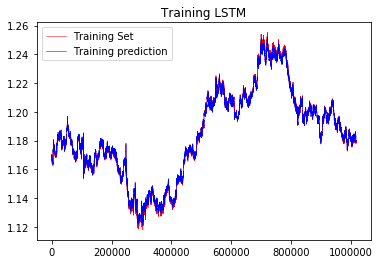

In [83]:
fig, ax = plt.subplots()
ax.plot(ytrain_norm, c = 'r', label = 'Training Set',linewidth=0.5)
ax.plot(ytrain_predict_inv_norm, c = 'b', label = 'Training prediction',linewidth=0.5)
plt.title('Training LSTM')
plt.savefig('/Users/stevenovis/Desktop/final_project/lstm_training')
ax.legend()

In [64]:
ytest_predict = model.predict(xtest)
ytest_predict_inv = scaler.inverse_transform(ytest_predict)
ytest_predict_inv_norm = np.reshape(ytest_predict_inv, ytest_predict_inv.shape[0])
ytest_norm = scaler.inverse_transform(ytest.reshape(-1,1))
ytest_norm_inv = np.reshape(ytest_norm, ytest_predict_inv.shape[0])

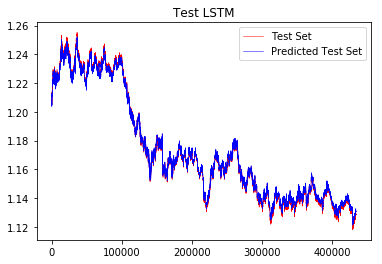

In [82]:
fig, ax = plt.subplots()
ax.plot(ytest_norm_inv, c = 'r', label = 'Test Set', linewidth=0.5)
ax.plot(ytest_predict_inv_norm, c='b', label = 'Predicted Test Set', linewidth=0.5)
plt.title('Test LSTM')
ax.legend()
plt.savefig('/Users/stevenovis/Desktop/final_project/lstm_test')
plt.show()

In [65]:
test_index = test.index.values

test_df = pd.DataFrame({'Actual':ytest_norm_inv, 
                        "Prediction":ytest_predict_inv_norm}, index = test_index[2:]).round(4)
print(type(test_df.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [66]:
class test_lstm:
    def __init__(self,data, shares, portfolio_value, commission):
        self.data = data
        self.actual = data['Actual'].tolist()
        self.predict = data['Prediction'].tolist()
        self.shares = shares
        self.portval = portfolio_value
        self.commission = commission
        self.position = False
        self.port = []
    def backtest(self):
        for i in range(0,len(self.data)-1):
            if self.position == False:
                if self.predict[i+1] > self.actual[i]:
                    print(f"Long {self.shares} at {self.actual[i]}")
                    self.portval = self.portval - ((self.actual[i] * self.shares)-self.commission)
                    self.position = True
                    print(f"Portfolio Value: {self.portval}")
                    self.port.append(self.portval)
            elif self.position == True:
                if self.predict[i+1] < self.actual[i]:
                    print(f"Close : {self.shares} at {self.actual[i]}")
                    self.portval += ((self.actual[i] * self.shares)- self.commission)
                    self.position = False
                    print(f"Portfolio Value: {self.portval}")
                    self.port.append(self.portval)
            
            else:
                continue
        return self.portval
    
                
                
                
    

Portfolio = 12,500 levered 20:1 = 250,000 to trade. In addition, Final Portfolio value is 250,0889.99. There was a trade at the end

In [84]:
test = test_lstm(test_df, 100000, 250000, -0.01)
test.backtest()

Long 100000 at 1.1956
Portfolio Value: 130439.99
Close : 100000 at 1.1958
Portfolio Value: 250020.0
Long 100000 at 1.1956
Portfolio Value: 130459.99
Close : 100000 at 1.1957
Portfolio Value: 250030.0
Long 100000 at 1.1956
Portfolio Value: 130469.99
Close : 100000 at 1.1959
Portfolio Value: 250060.0
Long 100000 at 1.1956
Portfolio Value: 130499.99
Close : 100000 at 1.196
Portfolio Value: 250100.0
Long 100000 at 1.1956
Portfolio Value: 130539.99
Close : 100000 at 1.1957
Portfolio Value: 250110.0
Long 100000 at 1.1956
Portfolio Value: 130549.99
Close : 100000 at 1.1957
Portfolio Value: 250120.0
Long 100000 at 1.1955
Portfolio Value: 130569.99
Close : 100000 at 1.1957
Portfolio Value: 250140.0
Long 100000 at 1.1955
Portfolio Value: 130589.99
Close : 100000 at 1.1959
Portfolio Value: 250180.0
Long 100000 at 1.1956
Portfolio Value: 130619.99
Close : 100000 at 1.1953
Portfolio Value: 250150.0
Long 100000 at 1.1955
Portfolio Value: 130599.99
Close : 100000 at 1.1953
Portfolio Value: 250130.0
L

132369.98999999964